In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df_train = pd.read_csv('Job titles and industries.csv')

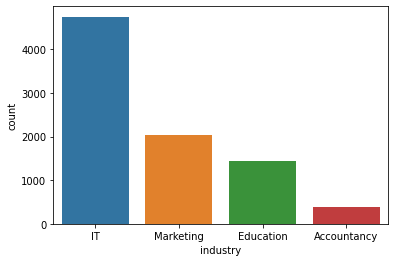

In [ ]:
sns.countplot(x='industry', data=df_train)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


*   Let's inspect how each job title differs with respect to industry.

In [ ]:
df_train.drop_duplicates(inplace=True)

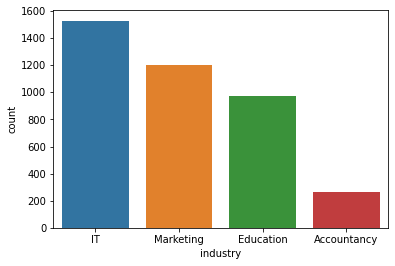

In [ ]:
sns.countplot(x='industry', data=df_train)

In [ ]:
df_train.groupby('industry').head(10)

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT
5,privileged access management expert,IT
6,devops engineers x 3 - global brand,IT
8,data modeller,IT
9,"php web developer £45,000 based in london",IT
12,solution / technical architect - ethical brand,IT


In [ ]:
df_temp = df_train.copy()

# **Now let's start preprocessing**


*   Lowercase all job titles.
*   Strip the text, to avoid any trailing spaces.
*   Remove special characters and numbers from job titles. e.g: salary
*   Remove stop words from job titles and make sure that each word is greater than 1 in length.


In [ ]:
df_temp['job title'] = df_train['job title'].str.lower()

In [ ]:
df_temp['job title'] = df_train['job title'].str.strip()

In [ ]:
df_temp['job title'] = df_temp['job title'].apply(lambda x : re.sub(r"[^a-zA-Z]"," ",x))

In [ ]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(job_title):
  words_tokenised = word_tokenize(job_title)
  filtered_job_title = [word for word in words_tokenised if ((not word in stop_words) or word=='it') and (len(word) > 1)]
  return " ".join(filtered_job_title)

In [ ]:
df_temp['job title'] = df_temp['job title'].apply(lambda x : remove_stopwords(x))

**Let's see again the first 10 records of each industry category after some preprocessing**

In [ ]:
df_temp.groupby('industry').head(10)

,job title,industry
0,technical support helpdesk supervisor county b...,IT
1,senior technical support engineer,IT
2,head it services,IT
3,js front end engineer,IT
4,network telephony controller,IT
5,privileged access management expert,IT
6,devops engineers global brand,IT
8,data modeller,IT
9,php web developer based london,IT
12,solution technical architect ethical brand,IT


**After further investigation on data it's found that:**
*   There are some misspelled words like 'acccount'. Solved by using sym_spell library.
*   Some variations to same word as: 'academic', 'academy'. This problem can be solved by getting stem of word.



In [ ]:
ps = PorterStemmer()

def correct_stem_line(job_title):
  words_tokenised = word_tokenize(job_title)
  filtered_job_title = [sym_spell.lookup(ps.stem(word), Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term for word in words_tokenised]
  return " ".join(filtered_job_title)

In [ ]:
df_temp['job title'] = df_temp['job title'].apply(lambda x : correct_stem_line(x))

#**Now that we are done with data preprocessing we start to:**

*   Encode target variable.
*   Split data into train and test.
*   Using stratify allows us to handle the data imblance problem when splitting. 
*   'Vectorizing data' : Transform X-data into numerical form by using CountVectorizing.
*   Using bigram and unigram, so that we try to capture most important aspects of job titles e.g: 'js developer'







In [ ]:
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df_temp['industry'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_temp['job title'], y, stratify=y, test_size=0.15, random_state=123)

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
X_vec_train = vectorizer.fit_transform(X_train)
X_vec_test = vectorizer.transform(X_test)

# **Model building phase**


## **I decided using svm because it is an efficient classification method when the feature vector is high dimensional and gives good results**

In [ ]:
svm_model = SVC().fit(X_vec_train, y_train)
svm_predictions = svm_model.predict(X_vec_test)
 
accuracy = svm_model.score(X_vec_test, y_test)
 
# creating a confusion matrix and classification report
cr = classification_report(y_test, svm_predictions)
cm = confusion_matrix(y_test, svm_predictions, svm_model.classes_)

## **Now to the evaluation:**

*   The accuracy of model on test data is 90.6%
*   But since accuracy is never a good measure we can see both classification report and confusion matrix below.
*   We can see that due to the imbalance in data, for class Accountancy we get low precision, recall and f1-score since the size of class is 39 observations



In [ ]:
accuracy

0.9060402684563759

In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.82      0.89        39
           1       0.95      0.90      0.93       146
           2       0.91      0.93      0.92       230
           3       0.85      0.89      0.87       181

    accuracy                           0.91       596
   macro avg       0.92      0.89      0.90       596
weighted avg       0.91      0.91      0.91       596



In [ ]:
cm

array([[ 32,   0,   3,   4],
       [  0, 132,   1,  13],
       [  0,   4, 215,  11],
       [  1,   3,  16, 161]])

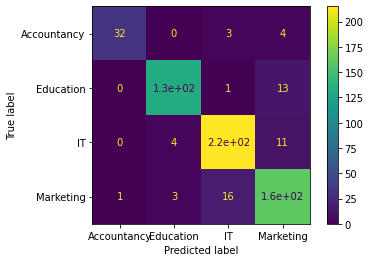

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_encoder.inverse_transform(svm_model.classes_))
disp.plot() 

# Now let's save our important objects to use later in API

In [ ]:
import pickle
def save_binary(object, name):
  with open(name, 'wb') as fout:
    pickle.dump(object, fout)

In [ ]:
save_binary(svm_model, 'svm_clf.sav')
save_binary(vectorizer, 'vectorizer.sav')
save_binary(target_encoder, 'target_encoder.sav')